### Fourier Transform Solution of Poisson Problems with Periodic Boundaries

In [1]:
%matplotlib inline

import numpy as np
from scipy.fft import fftn, ifftn, fftshift, ifftshift, fftfreq
from scipy.special import erf, expi, exp1, sici
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import axes_grid1

def add_colorbar(im, ax, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

pi = np.pi

plt.rcParams['figure.dpi'] = 200

As a test problem we will use
$$ \rho = 12 \pi^2 a^2 \cos(a 2\pi x) \cos(a 2\pi y) \cos(a 2\pi z) $$
 with solution
$$ \phi = \cos(a 2\pi x) \cos(a 2\pi y) \cos(a 2\pi z) $$
on $[-\frac{1}{2},\frac{1}{2}]^3$. The function is periodic on this domain if $a$ is an integer; we will use $a=2$ in our tests.

Here is the test problem, along with some functions to plot the results of our experiments

In [84]:
def rho3d(x,y,z, a):
    return  (12*a**2*pi**2) * \
            np.cos(a*2*pi*x) * np.cos(a*2*pi*y) * np.cos(a*2*pi*z)

def phi3dExact(x,y,z, a):
    return  np.cos(a*2*pi*x) * np.cos(a*2*pi*y) * np.cos(a*2*pi*z) 

# some error norms
def normMax(x):
    return np.max(np.abs(x.flatten()))
def normRMS(x):
    return np.sqrt(np.average(x**2))

def plotit(phi, ans):
    error = np.abs(ans-phi)
    L2error = normRMS(error)
    print(f"RMS error: {L2error}")
    inferror = normMax(error)
    indx = np.unravel_index(np.argmax(np.abs(error)), error.shape)
    print(f"max-norm error: {inferror} at {indx}")
    
    fig, ax = plt.subplots(2,3)
    c0 = ax[0,0].imshow(ans[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb0 = add_colorbar(c0, ax[0,0])
    ax[1,0].plot(ans[:,N//2,N//2])
    ax[1,0].set_xlabel("exact")

    c1 = ax[0,1].imshow(phi[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb1 = add_colorbar(c1, ax[0,1])
    ax[1,1].set_xlabel("solution")
    ax[1,1].plot(phi[:,N//2,N//2])

    c2 = ax[0,2].imshow(error[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb2 = add_colorbar(c2, ax[0,2])
    ax[1,2].set_xlabel("error")
    ax[1,2].plot(error[:,N//2,N//2])

    plt.tight_layout();

The Green's function for Poisson's equation is
$$ G(\mathbf{r}) = \frac{1}{4\pi|\mathbf{r}|}$$
If we take the Fourier transform (not the DFT) of this, we have
$$ \hat(G)(\mathbf{k}) = \frac{1}{|\mathbf{k}|} $$
The Fourier Green's function is thus singular at wave vector $|\mathbf{k}|=0$, but this is not a problem. $\hat{\phi}(0)$ describes the DC component of the DFT -- the sum of all the elements on the grid. For the solution to Poisson's equation to exist, we must satsify the integrability condition $\int_\Omega \rho(\mathbf{r}) dV = 0$. In this case, must have $\hat{\phi}(0) = 0$, and so we may set $\hat(G)(\mathbf{k})=0$ arbitrarily, to any (finite) value we wish.

Let's try using this Fourier Green's function to solve our test problem. As once can see, the method achieves spectral accuracy as long as the function is sampled adequately

1.0000000000000002 0.9999999999999998
RMS error: 1.311967342397446e-16
max-norm error: 6.661338147750939e-16 at (33, 61, 50)


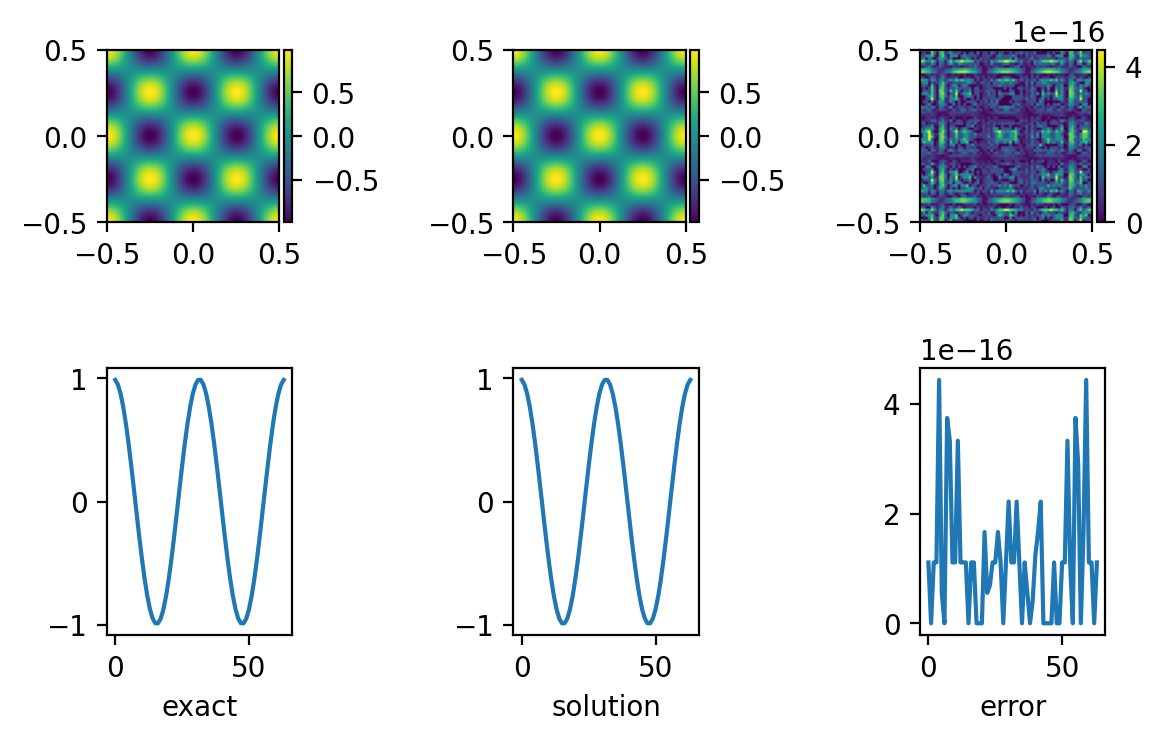

In [195]:
N = 64
xmin, xmax = np.array([-0.5,0.5])*1 # can set size of box here
L = xmax - xmin
h = L/N

x1d = np.arange(xmin+h/2, xmax+h/2, h)
x,y,z = np.meshgrid(x1d, x1d, x1d)
a = 2
rho = rho3d(x,y,z,a)
ans = phi3dExact(x,y,z,a)

k = fftfreq(N,h)*2*pi
na = np.newaxis
Ghat = 1/(k[:,na,na]**2 + k[na,:,na]**2 + k[na,na,:]**2 + 1e-38)#/(4*pi**2)
Ghat[0,0,0] = 0

fargs = { 'workers':12, 'overwrite_x':True }
phi = ifftn( fftn(rho, **fargs) * Ghat, **fargs).real

rat = phi[N//2,N//2,N//2] / ans[N//2,N//2,N//2]
print(rat, 1/rat)
plotit(phi, ans)

Often one discretizes the Laplacian operator using a finite-difference approximation
and takes the transform of this finite-difference to obtain a discrete Green's function. This can be useful for more complex boundary conditions, but is limited by the truncation error of the finite difference representation of the Laplacian.

A second-order finite-difference approximation to
the 1D Poisson problem is
$$ \frac{\phi_{j+1} - 2\phi_j + \phi_{j-1}}{h^2} = -\rho_j $$
The inverse DFT of $\hat{\phi}$ is 
$$ \phi_j = \frac{1}{Nh} \sum_{n=0}^{N-1} e^{-2\pi i n j/N} \hat{\phi}_n $$
Substituting this into the finite difference equation
$$ \frac{1}{N h^3} \left[ \sum_{n=0}^{N-1} e^{-2\pi i n (j+1)/N} \hat{\phi}_n - 2 \sum_{n=0}^{N-1} e^{-2\pi i n (j)/N} \hat{\phi}_n + \sum_{n=0}^{N-1} e^{-2\pi i n (j-1)/N} \hat{\phi}_n \right] = - \frac{1}{N h} \sum_{n=0}^{N-1} e^{-2\pi i n (j)/N} \hat{\rho}_n $$
Cancelling terms, this is
$$ \frac{1}{h^2} \left[ \sum_{n=0}^{N-1} e^{-2\pi i n/N} \hat{\phi}_n - 2 \sum_{n=0}^{N-1} \hat{\phi}_n + \sum_{n=0}^{N-1} e^{+2\pi i n /N} \hat{\phi}_n \right] = - \sum_{n=0}^{N-1} \hat{\rho}_n $$
This can only be true in general if 
$$  \frac{1}{h^2} \hat{\phi}_n \left[ e^{-2\pi i n/N} - 2 +  e^{+2\pi i n /N} \right] = - \hat{\rho}_n $$
which, using Euler's formula, is
$$  \frac{1}{h^2} \hat{\phi}_n \left[ 2 \cos(2\pi n/N) - 2 \right] = - \hat{\rho}_n $$
Using the half-angle identity $ 1-\cos(x) = 2\sin^2(x/2)$
we have
$$ \frac{1}{h^2} \hat{\phi}_n \left[ -4 \sin^2(\pi n/N) \right] = - \hat{\rho}_n $$
rearranging
$$ \hat{\phi}_n = \left(\frac{\sin(\pi n/N)}{h/2}\right)^{-2} \hat{\rho}_n $$
In three dimensions, then, we have
$$ G(\mathbf{k}) = \left[\left(\frac{\sin(k_x)}{h/2}\right)^2 + \left(\frac{\sin(k_y)}{h/2}\right)^2 + \left(\frac{\sin(k_z)}{h/2}\right)^2\right]^{-1} $$
with the wave vectors
$$ k_n = \frac{\pi n}{N}, \quad n=0,\dots,N-1 $$


RMS error: 0.0002841076131471297
max-norm error: 0.0008035776793720029 at (0, 0, 0)


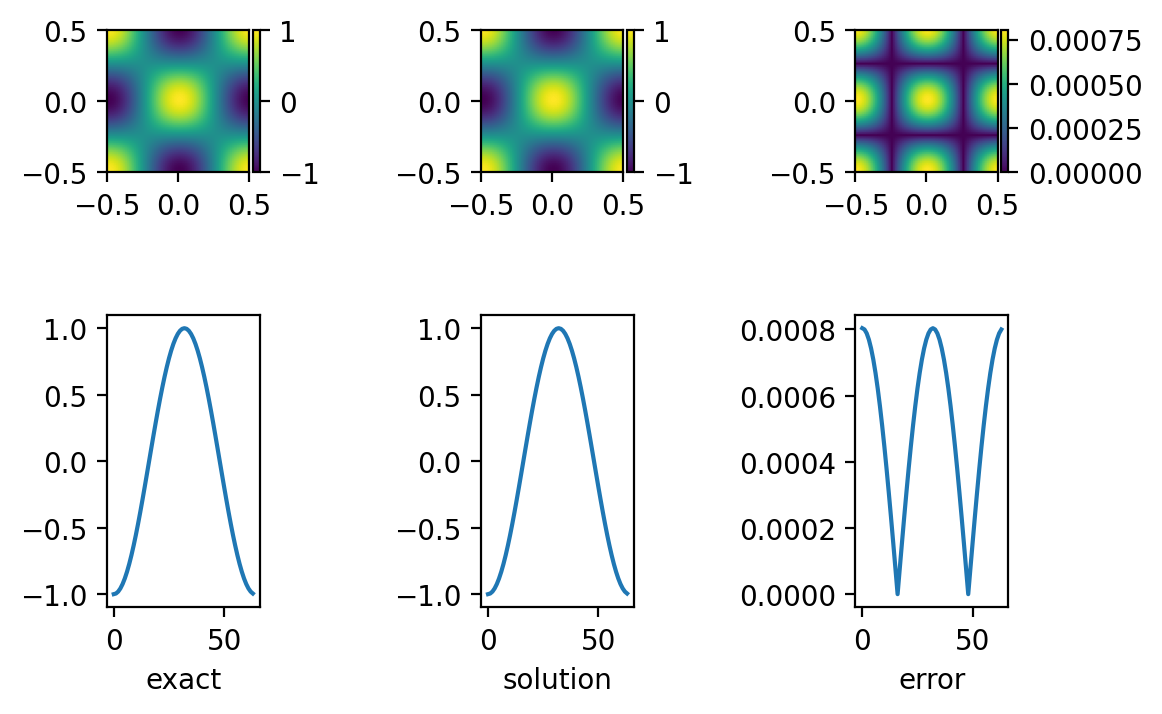

In [176]:
N = 64
xmin, xmax = np.array([-0.5,0.5])*1 # can set size of box here
L = xmax - xmin
pi = np.pi
h = L/N

x1d = np.arange(xmin, xmax, h)
x,y,z = np.meshgrid(x1d, x1d, x1d)
a = 1
rho = rho3d(x,y,z,a)
ans = phi3dExact(x,y,z,a)

k = fftfreq(N,1)*pi
na = np.newaxis
Ghat = 1/((np.sin(k[ :,na,na])/(0.5*h))**2 + \
          (np.sin(k[na, :,na])/(0.5*h))**2 + \
          (np.sin(k[na,na, :])/(0.5*h))**2 + 1.0e-38)
Ghat[0,0,0] = 0

fargs = { 'workers':12, 'overwrite_x':True }
phi = ifftn( fftn(rho, **fargs) * Ghat, **fargs).real

plotit(phi, ans)

In [166]:
def finiteDiff2(N,L):
    
    xmin, xmax = np.array([-0.5,0.5])*L # can set size of box here
    L = xmax - xmin
    pi = np.pi
    h = L/N

    x1d = np.arange(xmin, xmax, h)
    x,y,z = np.meshgrid(x1d, x1d, x1d)
    a = 1
    rho = rho3d(x,y,z,a)
    ans = phi3dExact(x,y,z,a)

    k = fftfreq(N,1)*pi
    na = np.newaxis
    Ghat = 1/((np.sin(k[ :,na,na])/(0.5*h))**2 + \
              (np.sin(k[na, :,na])/(0.5*h))**2 + \
              (np.sin(k[na,na, :])/(0.5*h))**2 + 1.0e-38)
    Ghat[0,0,0] = 0

    fargs = { 'workers':12, 'overwrite_x':True }
    phi = ifftn( fftn(rho, **fargs) * Ghat, **fargs).real

    error = phi-ans
    return normMax(error)

Text(0, 0.5, '$|\\phi-\\phi_e|_\\infty$')

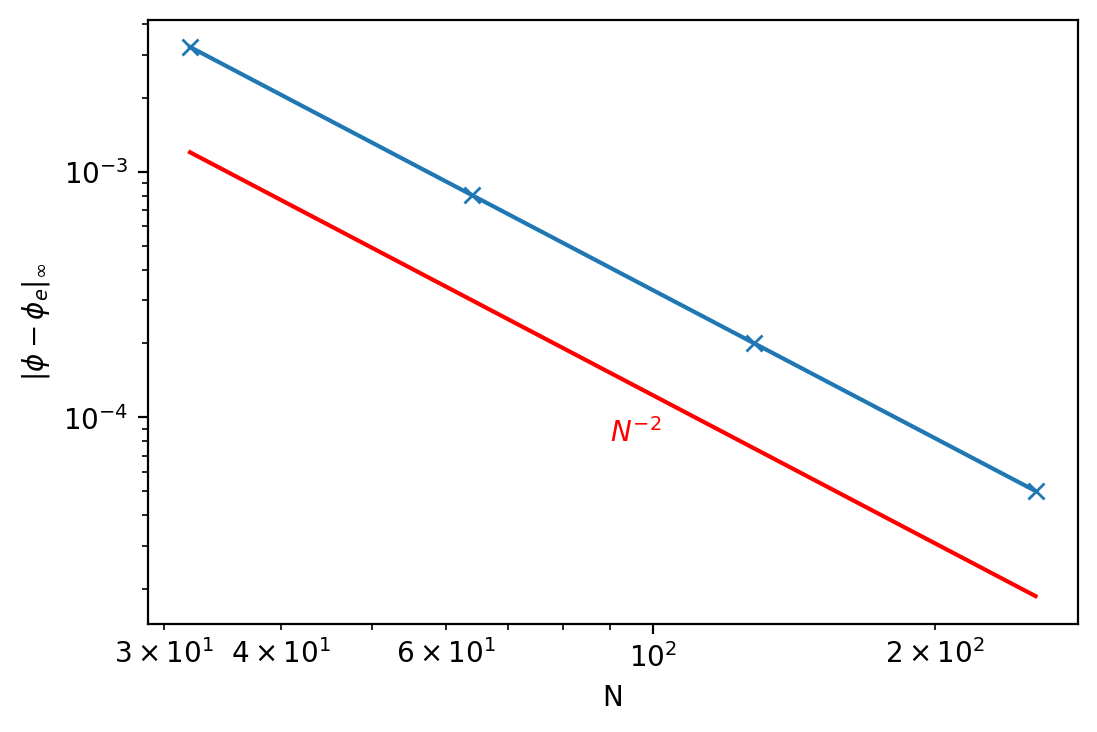

In [174]:
n = []
e = []
for i in range(5,9):
    N = 2**i
    n.append(N)
    e.append(finiteDiff2(N,1))

fig,ax = plt.subplots()
ax.loglog(n,e,'-x')
ax.loglog([32,256],[0.0012,0.0012/64],'r')
ax.text(90,.00008,r'$N^{-2}$',c='r')
ax.set_xlabel('N')
ax.set_ylabel(r'$|\phi-\phi_e|_\infty$')